# Домашнее задание для Junior DS по разработке PD модели

<b>Задание:</b> Необходиом разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д). Результат будет оцениваться на скрытой выборке из 200 компаний по метрике качества accuracy_score

<b>Цель задания</b> научиться / показать знания в разработке моделей оценки риска - probability of default. Задание приближено к реальному, данные синтетические. Лидерборд для оценки собственного решения и геймификации процесса обучения. Первое место в лидерборде не явлется целью. Цель - правильно разарботанная модель, удовлетворяющая требованиям банковской системы. В случае возникновения вопросов, сотрудники блока Риски готовы проконсультировать и дать обратную связь на модель (телеграм чат).

<b>Метрика качества</b> accuracy_score вычисляется, как ( True positive + True negative ) / Total. Если сабмит-файл, не правильного формата или неверное количество строк, метрика будет = 0.

### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

### Подгружаем данные

In [2]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')
desc_df = pd.read_csv('PD-data-desc.csv', sep=';')

Описание данных

In [3]:
desc_df

,field,desc_eng,desc_rus
0,ar_revenue,Sales revenue (at the end of the last year),Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Total expenses for the last year,Общие расходы за последний год
2,ar_sale_cost,Cost of sales (at the end of the last year),Себестоимость продаж (на конец последнего года)
3,ar_selling_expenses,Selling expenses (at the end of the last year),Коммерческие расходы (на конец последнего года)
4,ar_management_expenses,Administrative expenses (at the end of the las...,Управленческие расходы (на конец последнего года)
5,ar_sale_profit,Profit from sales (at the end of the last year),Прибыль от реализации (на конец последнего года)
6,ar_balance_of_rvns_and_expns,Balance of income and expenses (at the end of ...,Баланс доходов и расходов (на конец последнего...
7,ar_profit_before_tax,Gross Profit (end of last year),Валовая прибыль (на конец последнего года)
8,ar_taxes,Current income tax (at the end of the last year),Текущий на налог на прибыль (на конец последне...
9,ar_other_profit_and_losses,Other income and expenses (at the end of the l...,Прочие доходы и расходы (на конец последнего г...


Семплы и размеры выборок

In [4]:
train_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,...,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28,28,28,[1-100],10000.0,2,0,0,0,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,...,8,8,8,[1-100],300000.0,1,0,0,0,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,...,27,27,27,[1-100],10000.0,2,0,0,0,0


In [5]:
train_df.shape

(32395, 37)

In [6]:
test_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg
0,196,39103000.0,38913000.0,38913000.0,0.0,0.0,190000.0,141000.0,331000.0,284000.0,...,135,3,3,3,[1-100],100000.0,1,0,0,0
1,1196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,138,5,5,5,[1-100],100000.0,1,0,0,0
2,2813,54174000.0,50929000.0,50929000.0,0.0,0.0,3245000.0,-1278000.0,1967000.0,500000.0,...,138,20,20,20,[1-100],250000.0,2,0,0,0
3,4385,1904000.0,1679000.0,1679000.0,0.0,0.0,225000.0,-88000.0,137000.0,0.0,...,139,9,9,9,[1-100],10000.0,2,0,0,0
4,6479,225584000.0,210685000.0,210685000.0,0.0,0.0,14899000.0,-12715000.0,2184000.0,445000.0,...,139,3,3,3,(100-500],1700598.0,84,0,0,0


In [7]:
test_df.shape

(200, 36)

### Работа с данными

In [8]:
# Посмотрим на баланс классов в датасете
train_df['default_12m'].value_counts()

0    30304
1     2091
Name: default_12m, dtype: int64

Видно что объектов первого класса сильно меньше чем нулевого.
Возникает проблема дисбаланса классов.

Модель выдает некоторые оценки принадлежности к классам (вероятности), а сама классификация – это результат бинаризации (по умолчанию порог = 0.5). Но порог можно подбирать, я буду использовать такую стратегию: с помощью cross validation подберу оптимальный порог для заданной метрики (в данном случае оценка проводится с помощью accuracy на сбалансированных выборках).
Этот же порог будем потом использовать на тесте.

Поскольку меня интересует не итоговая классификация модели, а правильное ранжирование объектов по вероятнстям, я буду максимизировать метрику roc-auc. Так как для хорошо отранжированных объектов, потом можно будет подобрать оптимальный порог бинаризации.

In [9]:
# Количество разных типов фичей
train_df.dtypes.value_counts()

float64    25
int64      11
object      1
dtype: int64

In [10]:
train_df.dtypes

record_id                         int64
ar_revenue                      float64
ar_total_expenses               float64
ar_sale_cost                    float64
ar_selling_expenses             float64
ar_management_expenses          float64
ar_sale_profit                  float64
ar_balance_of_rvns_and_expns    float64
ar_profit_before_tax            float64
ar_taxes                        float64
ar_other_profit_and_losses      float64
ar_net_profit                   float64
ab_immobilized_assets           float64
ab_mobile_current_assets        float64
ab_inventory                    float64
ab_accounts_receivable          float64
ab_other_current_assets         float64
ab_cash_and_securities          float64
ab_losses                       float64
ab_own_capital                  float64
ab_borrowed_capital             float64
ab_long_term_liabilities        float64
ab_short_term_borrowing         float64
ab_accounts_payable             float64
ab_other_borrowings             float64


##### В данных имеются несколько категориальных признаков

In [11]:
#1. ul_staff_range - порядковый признак, так как "[1-100]"<"(100-500]"<"> 500"  
train_df['ul_staff_range'].value_counts()

[1-100]      29281
(100-500]     2757
> 500          357
Name: ul_staff_range, dtype: int64

In [12]:
#Данный признак на всей обучающей выборке принимает одно значение, поэтому не несет в себе информации, далее удалю его
train_df['ul_systematizing_flg'].value_counts()

0    32395
Name: ul_systematizing_flg, dtype: int64

In [13]:
#Данный признак так же не несет ценности, так как только на трех объектах приимает значение 1, на остальных - 0
train_df['ul_strategic_flg'].value_counts()

0    32392
1        3
Name: ul_strategic_flg, dtype: int64

In [14]:
#Кодирую признак ul_staff_range
staff_encoder = {'[1-100]': 0, '(100-500]': 1, '> 500': 2}

train_df['ul_staff_range'].replace(staff_encoder, inplace=True)
test_df['ul_staff_range'].replace(staff_encoder, inplace=True)

In [15]:
#record_id  - просто индекс записи, тоже не несет информации
train_df.drop('record_id', axis=1, inplace=True)
test_df.drop('record_id', axis=1, inplace=True)

#### Работа с пропусками
В данных много пропущенных значений, около половины объектов имеют пропуски в большей части колонок(причем всегда в одинаковых).
Удаление таких записей сильно уменьший обучающий датасет, поэтому постараюсь заполнить их.

In [16]:
train_df.isna().sum()

ar_revenue                      15145
ar_total_expenses               15145
ar_sale_cost                    15145
ar_selling_expenses             15145
ar_management_expenses          15145
ar_sale_profit                  15145
ar_balance_of_rvns_and_expns    15145
ar_profit_before_tax            15145
ar_taxes                        15145
ar_other_profit_and_losses      15145
ar_net_profit                   15145
ab_immobilized_assets           15145
ab_mobile_current_assets        15145
ab_inventory                    15145
ab_accounts_receivable          15145
ab_other_current_assets         15145
ab_cash_and_securities          15145
ab_losses                       15145
ab_own_capital                  15145
ab_borrowed_capital             15145
ab_long_term_liabilities        15145
ab_short_term_borrowing         15145
ab_accounts_payable             15145
ab_other_borrowings             15145
bus_age                             0
ogrn_age                            0
adr_actual_a

In [17]:
# Признаки без пропусков
not_nan = train_df.isna().sum()
not_nan_cols = list(not_nan[not_nan == 0].index)
not_nan_cols

['bus_age',
 'ogrn_age',
 'adr_actual_age',
 'head_actual_age',
 'cap_actual_age',
 'ul_staff_range',
 'ul_capital_sum',
 'ul_founders_cnt',
 'ul_branch_cnt',
 'ul_strategic_flg',
 'ul_systematizing_flg',
 'default_12m']

#### Заполнение пропусков
Для заполнения буду использовать простую линейную регрессию, которая по признакам без пропусков предсказывает пропущенные значения.

In [18]:
lr = LinearRegression()
imputer = IterativeImputer(estimator=lr,
                           missing_values=np.nan,
                           max_iter=100,
                           verbose=2,
                           imputation_order='roman',
                           random_state=0)

train_df_inp=imputer.fit_transform(train_df.drop('default_12m', axis=1))

[IterativeImputer] Completing matrix with shape (32395, 35)
[IterativeImputer] Ending imputation round 1/100, elapsed time 3.04
[IterativeImputer] Change: 366654592.0000656, scaled tolerance: 3349389.0 
[IterativeImputer] Ending imputation round 2/100, elapsed time 4.96
[IterativeImputer] Change: 434880688.0000662, scaled tolerance: 3349389.0 
[IterativeImputer] Ending imputation round 3/100, elapsed time 6.55
[IterativeImputer] Change: 336836312.0000661, scaled tolerance: 3349389.0 
[IterativeImputer] Ending imputation round 4/100, elapsed time 8.45
[IterativeImputer] Change: 255044224.00006798, scaled tolerance: 3349389.0 
[IterativeImputer] Ending imputation round 5/100, elapsed time 10.11
[IterativeImputer] Change: 192257312.00007066, scaled tolerance: 3349389.0 
[IterativeImputer] Ending imputation round 6/100, elapsed time 11.91
[IterativeImputer] Change: 144787680.00007266, scaled tolerance: 3349389.0 
[IterativeImputer] Ending imputation round 7/100, elapsed time 13.82
[Iterati

In [19]:
# Заполнил пропуски
cols = train_df.drop('default_12m', axis=1).columns
train_df_x = pd.DataFrame(train_df_inp, columns=test_df.columns)
test_df_x = pd.DataFrame(imputer.transform(test_df), columns=test_df.columns)

[IterativeImputer] Completing matrix with shape (200, 35)
[IterativeImputer] Ending imputation round 1/20, elapsed time 0.01
[IterativeImputer] Ending imputation round 2/20, elapsed time 0.02
[IterativeImputer] Ending imputation round 3/20, elapsed time 0.02
[IterativeImputer] Ending imputation round 4/20, elapsed time 0.03
[IterativeImputer] Ending imputation round 5/20, elapsed time 0.05
[IterativeImputer] Ending imputation round 6/20, elapsed time 0.06
[IterativeImputer] Ending imputation round 7/20, elapsed time 0.07
[IterativeImputer] Ending imputation round 8/20, elapsed time 0.09
[IterativeImputer] Ending imputation round 9/20, elapsed time 0.10
[IterativeImputer] Ending imputation round 10/20, elapsed time 0.11
[IterativeImputer] Ending imputation round 11/20, elapsed time 0.12
[IterativeImputer] Ending imputation round 12/20, elapsed time 0.12
[IterativeImputer] Ending imputation round 13/20, elapsed time 0.13
[IterativeImputer] Ending imputation round 14/20, elapsed time 0.14

In [20]:
train_df_x.head()

,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,...,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg
0,5.299600e+07,4.834400e+07,4.834400e+07,0.000000e+00,0.000000e+00,4.652000e+06,-2.608000e+06,2.044000e+06,846000.000000,0.000000,...,136.0,3.0,3.0,3.0,0.0,50000.0,2.0,0.0,0.0,0.0
1,8.153776e+07,7.678474e+07,7.320328e+07,2.499198e+06,1.082263e+06,4.753016e+06,-6.424773e+05,4.110538e+06,418807.105971,39373.043478,...,135.0,12.0,12.0,12.0,0.0,10000.0,5.0,0.0,0.0,0.0
2,8.153776e+07,7.678474e+07,7.320328e+07,2.499198e+06,1.082263e+06,4.753016e+06,-6.424773e+05,4.110538e+06,418807.105971,39373.043478,...,33.0,28.0,28.0,28.0,0.0,10000.0,2.0,0.0,0.0,0.0
3,3.204900e+07,2.956800e+07,2.956800e+07,0.000000e+00,0.000000e+00,2.481000e+06,-2.600000e+05,2.221000e+06,302000.000000,0.000000,...,139.0,8.0,8.0,8.0,0.0,300000.0,1.0,0.0,0.0,0.0
4,1.645800e+07,1.493500e+07,1.493500e+07,0.000000e+00,0.000000e+00,1.523000e+06,-2.740000e+05,1.249000e+06,538000.000000,0.000000,...,138.0,27.0,27.0,27.0,0.0,10000.0,2.0,0.0,0.0,0.0


#### Добавлю новые фичи
Добавлю новые признаки, построенные на "здравом смысле".
1. Отношение прибыли от реалтзации к выручке от реализации. Чем больше - тем лучше для компании.
2. Чистая прибыль / Капитал. Какую часть от капитала составляет чистая прибыль, насколько она его пополняет.
3. Общие долговые обязательства / Капитал. Чем меньше - тем лучше для компании.
4. Общие долговые обязательства / Запасы. Чем меньше - тем лучше для компании.
5. Запасы / Капитал. Какаую долю от капитала составляют запасы.
6. Чистая прибыль / Запасы.
7. Налог на прибыль / Прибыль от реализации. Чем меньше - тем лучше для компании.
8. Нераспределенная прибыль / Прибыль от реализации.

In [21]:
# Добавляю константу к знаменателю, чтобы избежать деления на ноль
def new_features(df):
    df['sale/revenue'] = df['ar_sale_profit'] / (df['ar_revenue'] + 1e-7)
    df['profit/capital'] = df['ar_net_profit'] / (df['ab_own_capital'] + 1e-7)
    df['bor/capital'] = df['ab_borrowed_capital'] / (df['ab_own_capital'] + 1e-7)
    df['bor/inventory'] = df['ab_borrowed_capital'] / (df['ab_inventory'] + 1e-7)
    df['inv/capital'] = df['ab_inventory'] / (df['ab_own_capital'] + 1e-7)
    df['profit/inventory'] = df['ar_net_profit'] / (df['ab_inventory'] + 1e-7)
    df['taxes/profit'] = df['ar_taxes'] / (df['ar_sale_profit'] + 1e-7)
    df['los/profit'] = df['ab_losses'] / (df['ar_sale_profit'] + 1e-7)
    
    return df

train_df_x = new_features(train_df_x)
test_df_x = new_features(test_df_x)

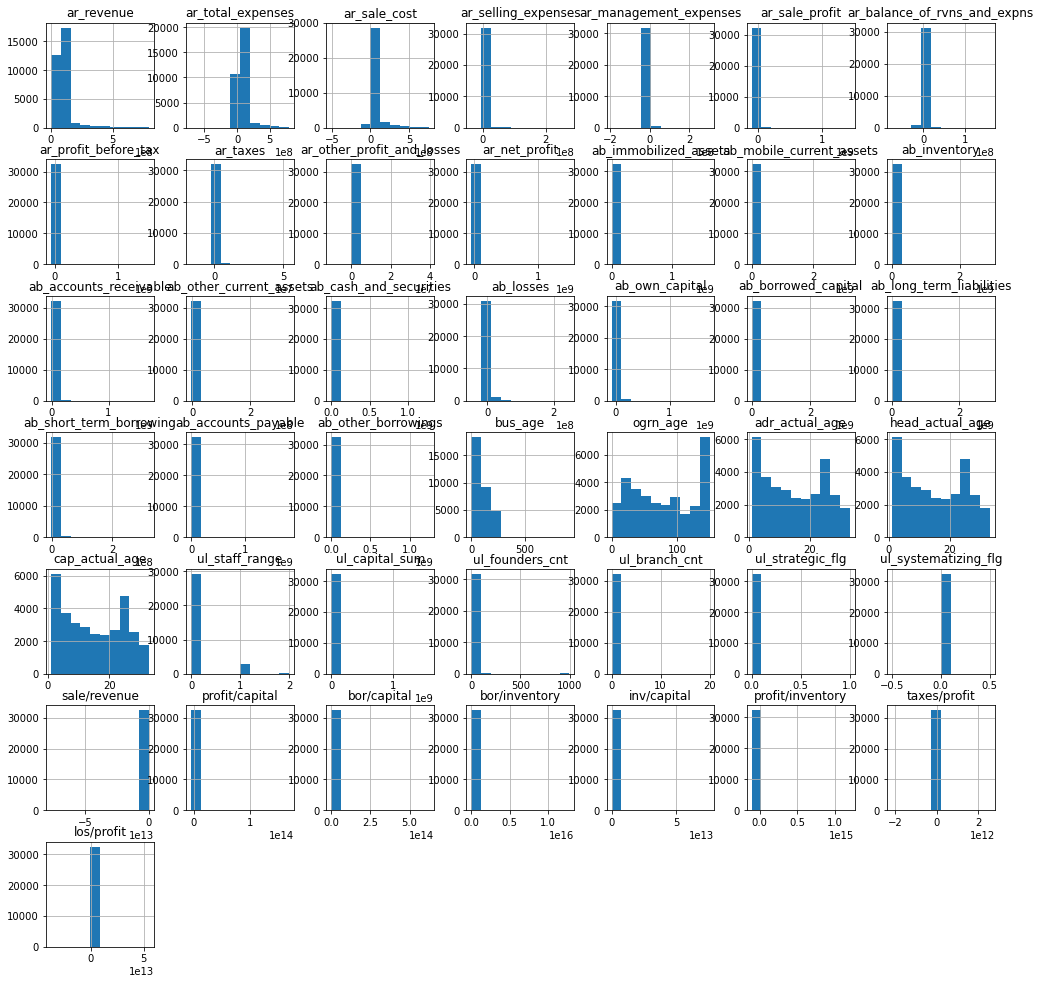

In [22]:
# Посмотрим на распределение признаков
train_df_x.hist(figsize=(17, 17));

#### Отбор фичей
Так как далее я буду использовать логистическую регрессию, необходимо избавиться от мультиколлинеарности признаков.
Для этого использую модуль FeatureSelector, который не является отдельной библиотекой. Он был найден мной на просторах интернета. Cсылка на питоновский файл: https://github.com/WillKoehrsen/feature-selector/blob/master/feature_selector/feature_selector.py

In [23]:
from feature_selector import FeatureSelector

X_train, y_train = train_df_x, train_df['default_12m']
fs = FeatureSelector(data = X_train, labels = y_train)

12 features with a correlation magnitude greater than 0.80.



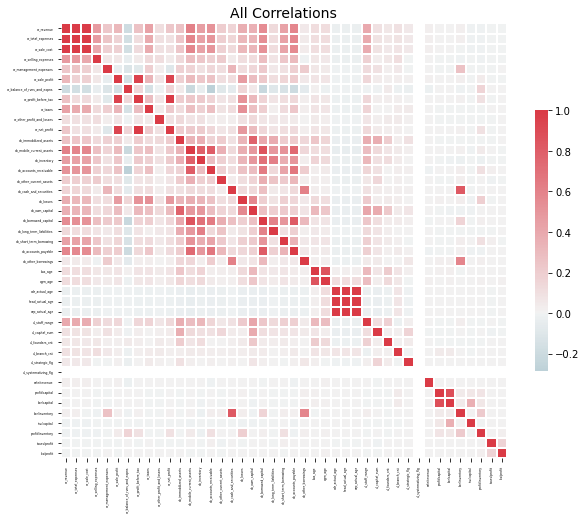

In [24]:
# установлю порого корреляции и выведу матрицу корреляции.
fs.identify_collinear(correlation_threshold = 0.8)
fs.plot_collinear(plot_all=True)

In [25]:
# Фичи для удаления
fs.record_collinear

,drop_feature,corr_feature,corr_value
0,ar_total_expenses,ar_revenue,0.988667
1,ar_sale_cost,ar_revenue,0.983769
2,ar_sale_cost,ar_total_expenses,0.993832
3,ar_profit_before_tax,ar_sale_profit,0.951916
4,ar_net_profit,ar_sale_profit,0.944014
5,ar_net_profit,ar_profit_before_tax,0.996629
6,ab_accounts_receivable,ab_mobile_current_assets,0.804130
7,ab_borrowed_capital,ab_mobile_current_assets,0.851014
8,ab_accounts_payable,ab_borrowed_capital,0.817119
9,ogrn_age,bus_age,0.857461


In [26]:
collinear_features = fs.ops['collinear']
collinear_features

['ar_total_expenses',
 'ar_sale_cost',
 'ar_profit_before_tax',
 'ar_net_profit',
 'ab_accounts_receivable',
 'ab_borrowed_capital',
 'ab_accounts_payable',
 'ogrn_age',
 'head_actual_age',
 'cap_actual_age',
 'bor/capital',
 'bor/inventory']

In [27]:
# Удаляю коррелирующие признаки и два категориальных, которые обсуждал выше
all_drop = collinear_features + ['ul_systematizing_flg', 'ul_strategic_flg']

# Разбиваем выборку
X_train, y_train = train_df_x.drop(all_drop, axis=1), \
                   train_df['default_12m']


X_test = test_df_x.drop(all_drop, axis=1)

#### Нормализация данных
Так же для линейных моделей важно подать данные с нормальным распределением, для этого использую преобразование box-cox (для приближения распределений к нормальному виду) и standart scaler (для z-преобразования. Среднее = 0, диспрерсия=1)

In [28]:
#box cox
#добавим константу к данным чтобы получить положительные значения
x_min = np.min(X_train) - 1
X_train = X_train - x_min
X_test = X_test - x_min

#применим преобразование
bc = PowerTransformer(method='box-cox')
X_train = bc.fit_transform(X_train)
X_test = bc.transform(X_test)

In [29]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [30]:
col = train_df_x.drop(all_drop, axis=1).columns
X_train = pd.DataFrame(X_train, columns=col)

X_test = pd.DataFrame(X_test, columns=col)

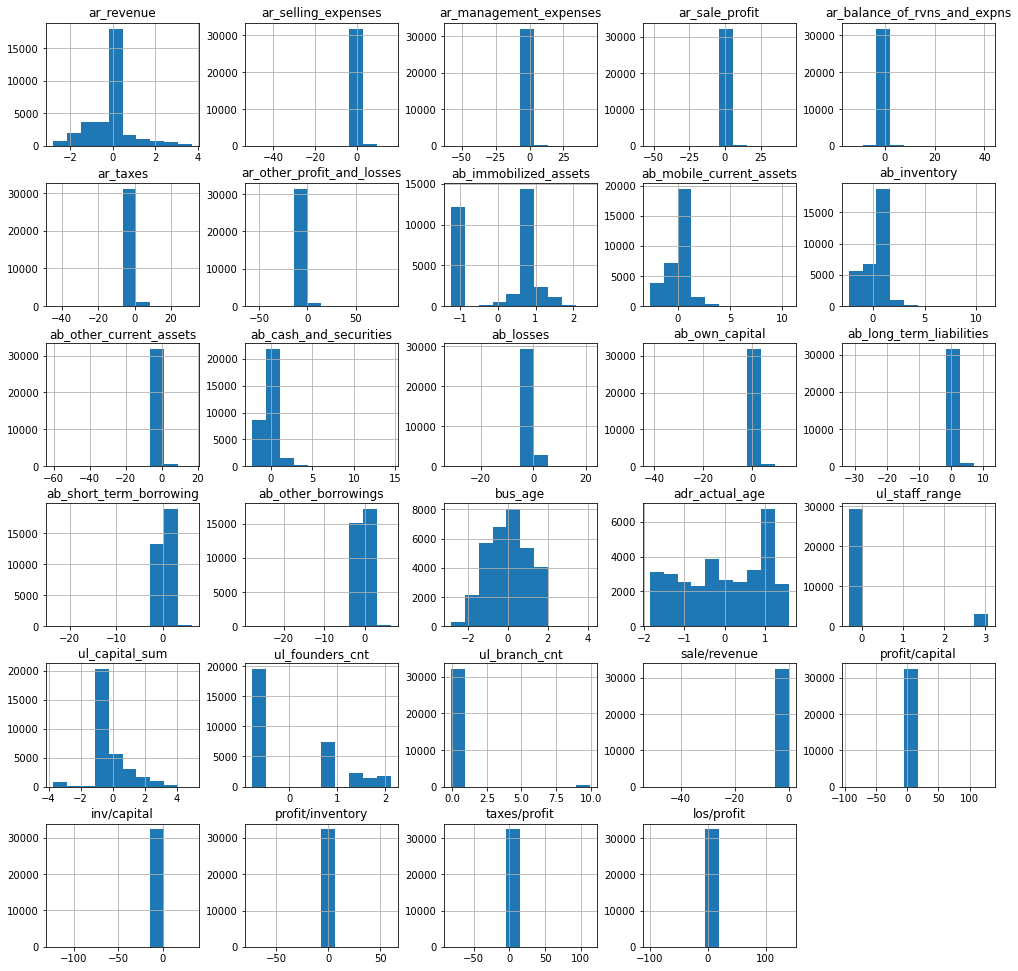

In [31]:
# Посмотрим на новые распределения признаков. Видно что стало гораздо лучше
X_train.hist(figsize=(17, 17));

Добавлю еще один новый признак с помощью KNN.
Для этого обучу KNN и добавлю новую колонку в данные - количество объектов первого класса среди ближайших 5 соседей

In [32]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [33]:
def train_kkn_feature_one(x):
    # Получаю индексы ближайших 5 соседей (n_neighbors=6, так как
    # на объектах обучающей выборки первым по близости соседом будет сам объект)
    ind = knn.kneighbors(X=[x], n_neighbors=6, return_distance=False)
    # считаю сумму таргетов соседей, что равно кол-ву объектов первого класаа
    one_count = np.sum(train_df['default_12m'].values[ind[0][1:]])
    return one_count

def test_kkn_feature_one(x):
    # все анлалогично первой функции, только n_neighbors=5, так как теперь
    # сам объект не находился в обучающей выборке
    ind = knn.kneighbors(X=[x], n_neighbors=5, return_distance=False)
    one_count = np.sum(train_df['default_12m'].values[ind[0]])
    return one_count


X_train['ones_count'] = list(map(train_kkn_feature_one, X_train.values))

X_test['ones_count'] = list(map(test_kkn_feature_one, X_test.values))


In [34]:
# Нормализую новую фичу, для дальнейшей интерпретации коэффициентов логистической регрессии.
X_train['ones_count'] = sc.fit_transform(X_train[['ones_count']])
X_test['ones_count'] = sc.transform(X_test[['ones_count']])

In [35]:
# Добавлю полиномиальных признаков 2й степени
for col in X_train.columns[:-1]:
    X_train[col+"_2"] = X_train[col]**2
    X_test[col+"_2"] = X_test[col]**2

In [36]:
X_train.head()

,ar_revenue,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_taxes,ar_other_profit_and_losses,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,...,ul_staff_range_2,ul_capital_sum_2,ul_founders_cnt_2,ul_branch_cnt_2,sale/revenue_2,profit/capital_2,inv/capital_2,profit/inventory_2,taxes/profit_2,los/profit_2
0,-0.071968,-0.389075,-0.192146,0.025590,-0.455819,0.435231,-0.121320,-1.256516,-0.760919,-0.450808,...,0.106349,0.093869,0.717656,0.010103,0.000878,0.000037,0.000170,0.001936,0.000031,0.000002
1,0.333922,0.079378,0.005572,0.037893,-0.005683,0.018680,0.006182,1.016016,0.355052,0.390327,...,0.106349,0.118864,2.872591,0.010103,0.000878,0.000037,0.001207,0.001936,0.000031,0.000002
2,0.333922,0.079378,0.005572,0.037893,-0.005683,0.018680,0.006182,0.711499,0.355052,0.390327,...,0.106349,0.118864,0.717656,0.010103,0.000878,0.000037,0.000821,0.001936,0.000031,0.000002
3,-0.479923,-0.389075,-0.192146,-0.241277,0.082160,-0.096336,-0.121320,-1.256516,-1.062237,-0.565638,...,0.106349,1.110124,0.613831,0.010103,0.000878,0.000037,0.000705,0.001936,0.000031,0.000002
4,-0.928318,-0.389075,-0.192146,-0.360560,0.078943,0.135545,-0.121320,-1.256516,-0.626367,-0.100310,...,0.106349,0.118864,0.717656,0.010103,0.000878,0.000037,0.001196,0.001936,0.000031,0.000002


#### Обучение
В соревновании оценка проводится с помощью accuracy, значит доля объектов каждого класса в тестовой выборке равны (это так же можно проверить залив константное предсказание и получив результат 0.5)
Чтобы оценить модель в схожих условиях и подобрать порог бинаризации я написал функцию my_cv:
1. Мы случайныс образом перемешиваем датасет
2. 5 раз Выбираем подвыборку из 200 элементов для теста (100 - 1-го класса, 100 - 0-го класса)
4. Обучаемся на остальных данных
3. Перебираем порог бинаризации и считаем метрику, находим оптимальный порог на каждом разбиении.

In [37]:
def my_cv(train_df, model, th):
    #Перемешиваем данные
    train_df = train_df.sample(frac=1)
    
    best_th = []
    best_score=[]
    for i in range(5):
        #Для валидацци выбираем по 100 объектов каждого класса
        val_df =  pd.concat([train_df[train_df['default_12m'] == 1].iloc[i*100:i*100+100,:], \
                             train_df[train_df['default_12m'] == 0].iloc[i*100:i*100+100,:]]).sample(frac=1)
        
        #Для обучения все остальное
        train_df =  pd.concat([train_df[train_df['default_12m'] == 1].iloc[i*100+100:,:], \
                               train_df[train_df['default_12m'] == 1].iloc[:i*100,:], \
                               train_df[train_df['default_12m'] == 0].iloc[i*100+100:,:], \
                               train_df[train_df['default_12m'] == 0].iloc[:i*100,:]]).sample(frac=1)
        
        X_train, y_train = train_df.drop('default_12m', axis=1), train_df['default_12m']
        X_val, y_val = val_df.drop('default_12m', axis=1), val_df['default_12m']
        
        #обучаю модель
        model.fit(X_train, y_train)
        
        #перебираю пороги и считаю метрику
        accuracy = []
        for cutoff in th:
            preds = (model.predict_proba(X_val)[:,1]>cutoff).astype(int)
            accuracy.append(accuracy_score(y_val, preds))
        
        #нахожу лиучший порог с максимальным результатом
        best_th.append(th[np.argmax(accuracy)])
        best_score.append(max(accuracy))
        print(f'mean_acc = {np.mean(accuracy)}')
        print(f'th: {th[np.argmax(accuracy)]}, score: {max(accuracy)}')
    print()
    #Усредненный порог разбиения по всем фолдам
    print(f'mean_th: {np.mean(best_th)}')
    #Срднее значение accuracy по всем фолдам
    print(f'mean_score: {np.mean(best_score)}')

In [38]:
#Функция для визуалтзации feature importance
def plot_feature_importance(importance,names,model_type):
    
    #массивы feature importances и названий признаков
    feature_importance = np.array(importance)[:]
    feature_names = np.array(names)[:]
    
    #Создаю датафрейм
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #сортирую по значению feature_importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    #строю barplot первых 25 фичей по значимости
    sns.barplot(x=fi_df['feature_importance'][:25], y=fi_df['feature_names'][:25])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [39]:
#собираю таргет и фичи вместе чтобы передать в my_cv()
train = X_train.copy(deep=True)
train['default_12m'] = y_train

In [40]:
#логистическая регрессия выдает 0.73 на кросс валидации
logit = LogisticRegression(max_iter=1000, n_jobs=-1)
cv_baseline = cross_val_score(logit, X_train, y_train, cv=5, scoring='roc_auc').mean()
cv_baseline

0.7301484572840664

In [41]:
# Посмотрим на оптимальный порог разбиения и значение accuracy
my_cv(train, logit, np.linspace(0,1,num=50))

mean_acc = 0.522
th: 0.08163265306122448, score: 0.67
mean_acc = 0.5223
th: 0.061224489795918366, score: 0.66
mean_acc = 0.5165
th: 0.061224489795918366, score: 0.645
mean_acc = 0.5196999999999999
th: 0.04081632653061224, score: 0.605
mean_acc = 0.5245000000000001
th: 0.04081632653061224, score: 0.75

mean_th: 0.05714285714285714
mean_score: 0.666


In [42]:
# Обучу на всех данных и построю feature importance
logit.fit(X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1)

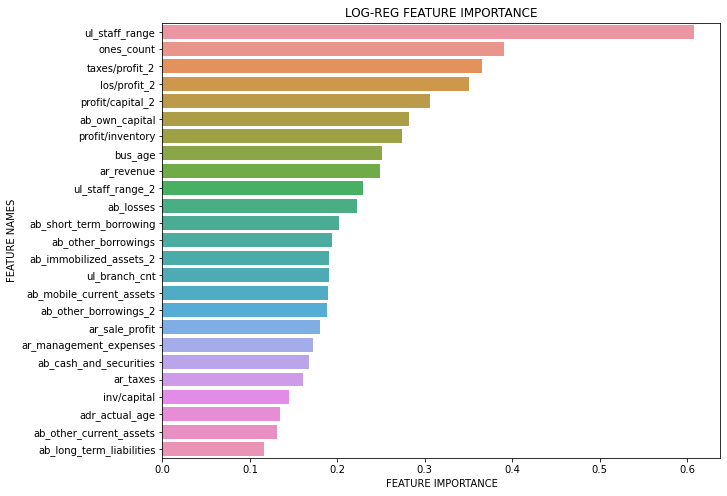

In [43]:
plot_feature_importance(np.abs(logit.coef_)[0],X_train.columns,'LOG-REG ')

Видно, что новые признаки и признаки во 2й степени имеют высокую значимость для модели

In [44]:
# Попробую случайный лес
rf = RandomForestClassifier()
cv_baseline = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc').mean()
cv_baseline

0.6831954117317132

In [45]:
rf.fit(X_train, y_train)

RandomForestClassifier()

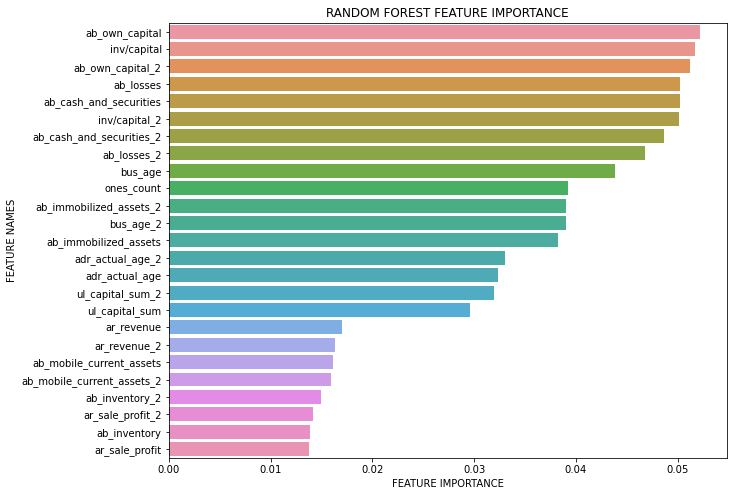

In [46]:
plot_feature_importance(rf.feature_importances_,X_train.columns,'RANDOM FOREST ')

In [47]:
# Попробую градиентный бустинг
cb = CatBoostClassifier(depth=4, n_estimators=200, verbose=False)
cv_baseline = cross_val_score(cb, X_train, y_train, cv=5, scoring='roc_auc').mean()
cv_baseline

0.7413652262692907

In [48]:
my_cv(train, cb, np.linspace(0,1,num=50))

mean_acc = 0.523
th: 0.1020408163265306, score: 0.65
mean_acc = 0.5423
th: 0.04081632653061224, score: 0.685
mean_acc = 0.5295000000000001
th: 0.061224489795918366, score: 0.73
mean_acc = 0.5211
th: 0.04081632653061224, score: 0.63
mean_acc = 0.5308999999999999
th: 0.08163265306122448, score: 0.685

mean_th: 0.06530612244897958
mean_score: 0.6759999999999999


In [49]:
cb.fit(X_train, y_train)

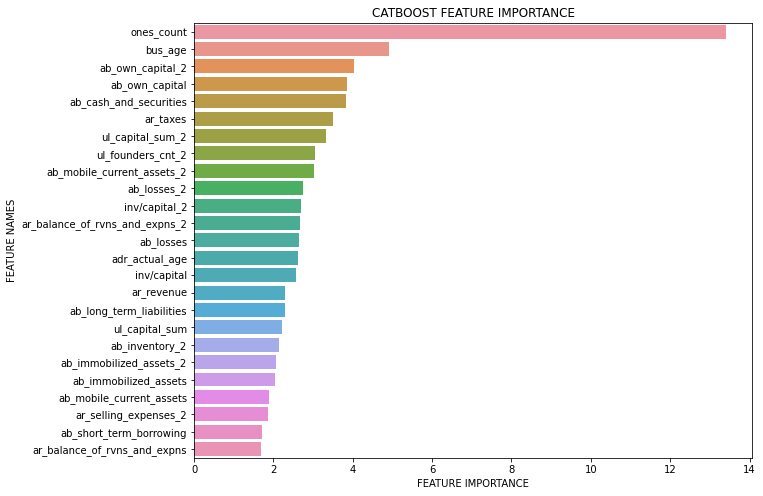

In [50]:
plot_feature_importance(cb.get_feature_importance(),X_train.columns,'CATBOOST ')

#### Подытог
Самый лучший результат показал catboost, но логистическая регрессия не сильно отстает.
Из задания: "Цель - правильно разарботанная модель, удовлетворяющая требованиям банковской системы".
Насколько я понимаю, для банка важно использовать легко интерпретируемые модели, чтобы они не были черным ящиком.
Соответственно модель должна быть не очень сложной, и логистическая регрессия для этого хорошо годится, да и ее результат не сильно отстает от бустинга.

Далее я попробовал использовать подход с использованием градиентного бустинга для перехода в новое признаковое пространство. Данных подход лишает итоговую модель легкой интерпретации, но заметно повышает качество на метриках, поэтому я использовал его тоже.

#### Новое признаковое пространство
Суть метода такова:
1. Обучаем градиентный бустинг на обучающей выборке
2. Затем прогоняем наши данные через обученный алгоритм и получаем индекс листа, в который попал наш объект
3. В итоге для каждого объекта получаем вектор из 200 (в данном случае, а вообще его длина равна количеству деревьев в алгоритме) индексов листов.
4. Делаем вектор one_hot кодирование, с итоговой длинной равной 200*(2^4), 2^4-количество листьев в дереве, 4-глубина дерева
5. Обучаем на one_hot векторе логистическую регрессию

In [51]:
# Получаю индексы для каждого объекта
train_pred = cb.calc_leaf_indexes(X_train)
test_pred = cb.calc_leaf_indexes(X_test)

In [52]:
# Так как глубина дерева 4, то кол-во листьев = 2**4, убедимся что индексы принимают значения из диапозона [0,2**4)
max(list(map(lambda x: max(x), train_pred))), min(list(map(lambda x: min(x), train_pred)))

(15, 0)

In [53]:
#Перевожу индексы листьев из пространства [0...L) (индексы уникальны в рамках дерева) 
#в формат [0...N*L) (индексы уникальны в рамках всего ансамбля). 

test_pred_new = list(map(lambda x: x + np.arange(0, len(x))*(2**4), test_pred))
train_pred_new = list(map(lambda x: x + np.arange(0, len(x))*(2**4), train_pred))

In [54]:
# Теперь каждый индекс глобальный, т.е по ним можно делать one_hot кодирование
print(f'local idx: {test_pred[0][:10]}')
print(f'global idx: {test_pred_new[0][:10]}')

local idx: [ 4  8  9 11 10  0 12 12  0  9]
global idx: [  4  24  41  59  74  80 108 124 128 153]


In [55]:
# 200 деревьев - 200 признаков
np.array(train_pred_new).shape, np.array(test_pred_new).shape

((32395, 200), (200, 200))

In [56]:
test_pred_onehot = np.zeros((200, 200*(2**4)))
train_pred_onehot = np.zeros((32395, 200*(2**4)))

In [57]:
# one_hot кодирование
for i in range(200):
    test_pred_onehot[i][test_pred_new[i].astype(int)] = 1

for i in range(32395):
    train_pred_onehot[i][train_pred_new[i].astype(int)] = 1

In [58]:
# получили 200*16 фичей
train_pred_onehot.shape, test_pred_onehot.shape

((32395, 3200), (200, 3200))

In [59]:
#Обучим логистическую регрессию
lr = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')
cv_baseline = cross_val_score(lr, train_pred_onehot, y_train, cv=5, scoring='roc_auc').mean()
cv_baseline

0.778558253363048

In [60]:
train = pd.DataFrame(train_pred_onehot)
train['default_12m'] = y_train

In [61]:
my_cv(train, lr, np.linspace(0,1,num=50))

mean_acc = 0.5606
th: 0.08163265306122448, score: 0.74
mean_acc = 0.5657
th: 0.08163265306122448, score: 0.735
mean_acc = 0.5668000000000001
th: 0.061224489795918366, score: 0.785
mean_acc = 0.5496000000000001
th: 0.04081632653061224, score: 0.74
mean_acc = 0.5529
th: 0.08163265306122448, score: 0.715

mean_th: 0.0693877551020408
mean_score: 0.743


In [62]:
lr.fit(train_pred_onehot, y_train)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

### submit

In [63]:
test_df = pd.read_csv('PD-data-test.csv', sep=';')
answ_df = test_df[['record_id']]
answ_df['id'] = answ_df['record_id']
answ_df.drop('record_id',axis=1, inplace=True)

In [75]:
answ_df['predict'] = (lr.predict_proba(test_pred_onehot)[:,1]>0.0612).astype(int)

In [74]:
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

In [76]:
answ_df['predict'].value_counts()

0    118
1     82
Name: predict, dtype: int64

Для загрузки своего рузультата на https://dsbattle.com/hackathons/juniords-new/ вам нужно создать csv файл с двумя колонками (id, predict), разделитель - точка с запятой (;)

### Результат
Данная  модель позволила добиться accuracy 0.655 на тестовом датасете
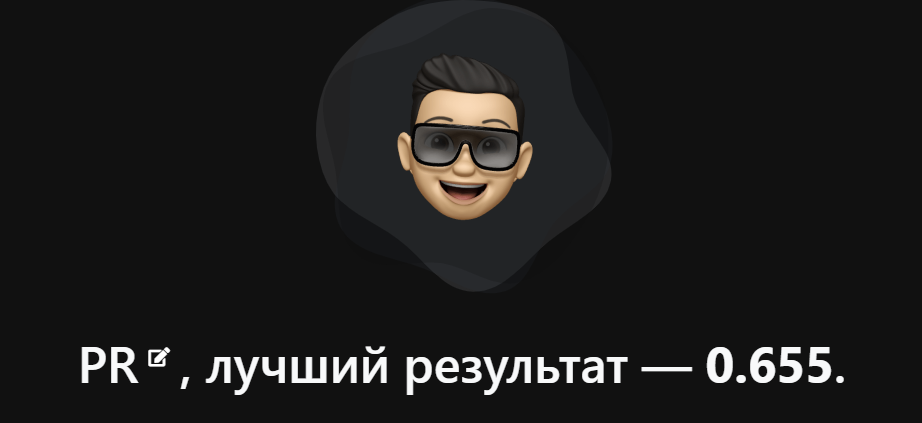